## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization, ConvLSTM2D
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape, Dropout
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D
from keras.callbacks import ModelCheckpoint, EarlyStopping

#leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
    
from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Using TensorFlow backend.


Notebook running on Python 3.8.11
Numpy version 1.20.3
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: [] )


## Load data from files

In [2]:
datasetRURpath = "dc21-rur-and-gpu-data/RUR/"
datasetGPUpath = "dc21-rur-and-gpu-data/GPU/"

### RUR

In [3]:
dfrur = pd.DataFrame()
files = glob.glob(datasetRURpath + "/20*.csv") 
for filename in files:
    data = pd.read_csv(filename)
    dfrur = dfrur.append(data, ignore_index=True)
print(dfrur.columns)
print(len(dfrur))
print(dfrur.head())

Index(['user_id', 'start_time', 'end_time', 'stime', 'utime', 'alps_exit',
       'alps_nppn', 'alps_width', 'alps_resid', 'aprun_id', 'command',
       'node_count', 'max_rss', 'rchar', 'wchar', 'gpu_mode', 'gpu_pids',
       'gpu_secs', 'gpu_maxsecs', 'gpu_maxmem', 'gpu_summem'],
      dtype='object')
12981186
    user_id                  start_time                    end_time  \
0  User2360  2019-06-12 19:23:37.686654  2019-06-12 19:32:09.182835   
1  User2360  2019-06-12 19:23:37.666163  2019-06-12 19:32:14.282770   
2  User2360  2019-06-12 19:23:37.667248  2019-06-12 19:32:19.860300   
3  User2360  2019-06-12 19:23:37.126212  2019-06-12 19:32:20.172509   
4  User2275  2019-06-12 19:07:07.288847  2019-06-12 19:33:20.797099   

       stime         utime  alps_exit  alps_nppn  alps_width  alps_resid  \
0  2764000.0  4.993480e+08          0        0.0         1.0     2251429   
1  2876000.0  5.056400e+08          0        0.0         1.0     2251429   
2  2788000.0  5.109680e+08     

In [4]:
print("Users: ", len(dfrur['user_id'].unique()))
print("Jobs: ", len(dfrur['user_id']))
print("Max nodes: ", max(dfrur['node_count']))

Users:  2372
Jobs:  12981186
Max nodes:  18688


In [5]:
dfrur['end_time'] = pd.to_datetime(dfrur['end_time'])
dfrur['start_time'] = pd.to_datetime(dfrur['start_time'])
dfrur["duration"] = (dfrur['end_time'] - dfrur['start_time']).dt.total_seconds()

In [6]:
dftask1 = dfrur.drop(dfrur.loc[dfrur['duration'] < 780].index, inplace=False) #13 minutes
dftask1.drop(dftask1.loc[dftask1["alps_exit"] != 0].index, inplace=True)
dftask1.drop(dftask1.loc[dftask1["gpu_secs"] < 1].index, inplace=True)

In [7]:
dftask2 = dftask1
dftask2["i_command_list"] = dftask2["command"].apply(lambda x: x.split("Area"))
dftask2["i_command_len"] = dftask2["i_command_list"].apply(lambda x: len(x))
dftask2.drop(dftask2.loc[dftask2["i_command_len"] == 1].index, inplace=True)
dftask2["area"] = dftask2["i_command_list"].apply(lambda x: x[1].split("-")[0])
dftask2["project"] = dftask2["i_command_list"].apply(lambda x: x[1].split("-")[1].split("/")[0])

Correlation data of jobs with the following metrics:
	Numerical-Numerical: Person's R [-1, 1]
	Nominal-Numerical (and VV): Correlation ratio [0,1] 


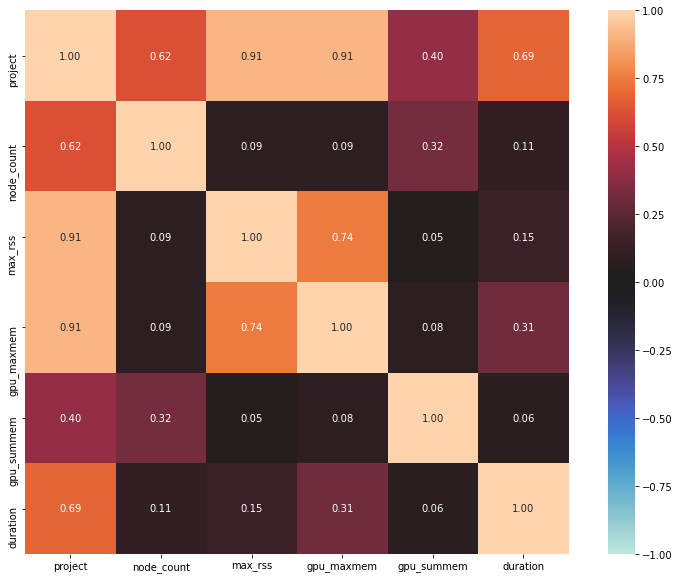

{'corr':              project  node_count   max_rss  gpu_maxmem  gpu_summem  duration
 project     1.000000    0.620112  0.910282    0.911526    0.399430  0.687212
 node_count  0.620112    1.000000  0.089805    0.086505    0.323666  0.108343
 max_rss     0.910282    0.089805  1.000000    0.742223    0.045663  0.145222
 gpu_maxmem  0.911526    0.086505  0.742223    1.000000    0.083847  0.308768
 gpu_summem  0.399430    0.323666  0.045663    0.083847    1.000000  0.064050
 duration    0.687212    0.108343  0.145222    0.308768    0.064050  1.000000,
 'ax': <AxesSubplot:>}

In [10]:
from dython.nominal import associations
dfAux = dftask2[[ 'project', 'node_count', 'max_rss', 'gpu_maxmem', 'gpu_summem', "duration"]]

print('Correlation data of jobs with the following metrics:')
print('\tNumerical-Numerical: Person\'s R [-1, 1]')
print('\tNominal-Numerical (and VV): Correlation ratio [0,1] ')
associations(dfAux,nominal_columns=["project"], figsize=(14,10))
#print('Number of jobs:', len(dfAux))